# Teaching with and Learning from Demonstration model
This notebook generates simulation data for four models: the doing demonstrator, showing model, naive observer, and sophisticated observer. Visualizations of these simulations are in the Visualization notebook.

In [1]:
import copy
from itertools import product
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mdp_lib.domains.gridworld import GridWorld
from planninginbeliefmodel import PlanningInObserverBeliefModel
from mdp_lib.domains.gridworldvis import visualize_trajectory, plot_text
from task import mdp_codes, mdp_params
from mdp_lib.util import sample_prob_dict
from util import mdp_to_feature_belief

np.random.seed(128374027)
np.seterr(under='ignore')

{'divide': 'raise', 'invalid': 'raise', 'over': 'raise', 'under': 'raise'}

# Parameters for doing and showing demonstration models

In [2]:
#doing model parameters
do_discount = .99
do_softmax = 0.08

#showing model parameters
base_discount_rate = .99
base_softmax_temp = 3.0
obmdp_discount_rate = .9
obmdp_softmax_temp= 1

# Doing model
This code builds doing models for the different MDPs that are defined in `task.py`. It also generates seed trajectories for building a discretized observer belief MDP (OBMDP) transition function. Using trajectories guided by what a doing agent would do helps focus the approximation on parts of the world-belief state space that are relevant.

In [3]:
doing_models = []
seed_trajs = []
for p in mdp_params:
    p = copy.deepcopy(p)
    p['discount_rate'] = do_discount
    m = GridWorld(**p)
    m.solve()
    doing_models.append(m)
    
    #generate seed trajectories for OBMDP discretization
    for _ in xrange(20):
        traj = m.run(temp=.7)
        if traj[-1][1] != '%':
            continue
        seed_trajs.append([(w, a) for w, a, _, _ in traj])
        
with open("./cached_values/seed_trajs.pkl", 'wb') as f:
    pickle.dump(seed_trajs, f)

# Showing model
This block builds showing models for the different possible OBMDPs using the `PlanningInObserverBeliefModel` class defined in `planninginbeliefmodel.py`. It discretizes the belief space using the `seed_trajs` generated in the previous block and solves the resulting (large) discrete MDP.

**Estimated running time: 6-8 mins**.

*Note that since the ground transition function is the same across all the ground MDPs considered here, the world-belief transitions are also the same. This means we can speed up computations slightly by reusing the transition function, `tf`.*

In [4]:
# Belief updates for doing model
m = PlanningInObserverBeliefModel(
    base_discount_rate = do_discount,
    base_softmax_temp = do_softmax,
    obmdp_discount_rate = obmdp_discount_rate,
    obmdp_softmax_temp=obmdp_softmax_temp,
    true_mdp_code=mdp_codes[0],
    discretized_tf=None
)
m.seed_beliefs_with_trajs(seed_trajs)
m.build()
m.solve()
showing_models_inner_temp = m.ob_mdp

In [ ]:
"""# Models you infer trajectories with
def gen_showing_trajs():
    showing_models = []
    for true_belief_reward in true_belief_rewards:
        tf = None
        for i, rfc in enumerate(mdp_codes):
            starttime = time.time()
            print rfc,
            m = PlanningInObserverBeliefModel(
                base_discount_rate = base_discount_rate,
                base_softmax_temp = base_softmax_temp,
                obmdp_discount_rate = obmdp_discount_rate,
                obmdp_softmax_temp=obmdp_softmax_temp,
                true_mdp_code=rfc,
                discretized_tf=tf,
                true_belief_reward=0
            )
            m.seed_beliefs_with_trajs(seed_trajs)
            m.build()
            m.solve()
            if true_belief_reward == 50:
                showing_models.append(m.ob_mdp)
            tf = m.ob_mdp.get_discretized_tf()
            print " %.2fs" % (time.time() - starttime)"""

In [6]:
showing_models = []
tf = None
for i, rfc in enumerate(mdp_codes):
    starttime = time.time()
    print rfc,
    m = PlanningInObserverBeliefModel(
        base_discount_rate = base_discount_rate,
        base_softmax_temp = base_softmax_temp,
        obmdp_discount_rate = obmdp_discount_rate,
        obmdp_softmax_temp=obmdp_softmax_temp,
        true_mdp_code=rfc,
        discretized_tf=tf
    )
    m.seed_beliefs_with_trajs(seed_trajs)
    m.build()
    m.solve()
    showing_models.append(m.ob_mdp)
    tf = m.ob_mdp.get_discretized_tf()
    print " %.2fs" % (time.time() - starttime)

 ooo  34.49s
oox  36.91s
oxo  38.78s
oxx  43.65s
xoo  40.29s
xox  41.40s
xxo  42.68s
xxx  87.46s


# Generating trajectories and calculating observer beliefs

The following two blocks generate *doing* and *showing* world-state/action trajectories using the models defined above. For each sequence of world-states and actions, we then calculate the change in the observer models' beliefs over time. The two models are the *naive* and *sophisticated* observers, which correspond to the following equations, respectively:

\begin{align}
b^{\text{Obs}}_{t+1}(M_i) &= P(M_i \mid w_t, a_t, w_{t+1})\\
&\propto P(a_t, w_{t+1} \mid w_t, M_i)P(M_i)\\
&= P(a_t \mid w_t, M_i)P(w_{t+1} \mid w_t, a_t, M_i)P(M_i)\\
&= \pi_{i}^{\text{Do}}(a_t \mid w_t)T_{i}(w_{t+1} \mid w_t, a_t)b_t^{\text{Obs}}(M_i).
\end{align}

and

\begin{align}
b^{\text{S-Obs}}_{t+1}(M_i) &= P(M_i \mid w_t, b^{\text{Obs}}_t, a_t, w_{t+1}, b^{\text{Obs}}_{t+1}) \\
&\propto \pi_i^{\text{Show}}(a_t \mid w_t, b_t^{\text{Obs}})T_i(w_{t+1} \mid w_t, a_t)b_t^{\text{S-Obs}}(M_i).
\end{align}

Each trajectory and final belief state is recorded in the `model_obs_judgments` dataframe and cached.

**Estimated running time: 20 min**

In [ ]:
def calc_obs_sobs_traj(wtraj):
    b_sobs = np.array(showing_models[0].get_init_state()[0])
    s = showing_models_inner_temp.get_init_state()
    inner_s = s
    
    obs_traj = [s[0],]
    sobs_traj = [b_sobs,]
    for w, a in wtraj:
        # get next naive belief
        ns = showing_models_inner_temp.transition(s=s, a=a)
        obs_traj.append(ns[0])
        
        # calc next sophisticated belief
        inner_ns = showing_models[0].transition(s=inner_s, a=a)
        show_a_probs = []
        for m in showing_models:
            a_probs = m.get_softmax_actionprobs(s=inner_s, temp=obmdp_softmax_temp)
            show_a_probs.append(a_probs[a])
        show_a_probs = np.array(show_a_probs)
        b_sobs = b_sobs*show_a_probs
        b_sobs = b_sobs/np.sum(b_sobs)
        sobs_traj.append(b_sobs)
        
        s = ns
        inner_s = inner_ns
    return {'obs_traj': obs_traj, 'sobs_traj': sobs_traj}

def is_correct(row):
    rf = dict(zip(['orange', 'purple', 'cyan'], row['rf']))
    if rf[row['color']] == 'x' \
            and row['exp_safe'] < .5:
        return True
    elif rf[row['color']] == 'o' \
            and row['exp_safe'] >= .5:
        return True
    return False

def calc_correct_prob(row):
    rf = dict(zip(['orange', 'purple', 'cyan'], row['rf']))
    if rf[row['color']] == 'x':
        return 1 - row['exp_safe']
    elif rf[row['color']] == 'o':
        return row['exp_safe']

In [ ]:
def gen_do_trajs(doing_models, showing_models, num_trajs=100):
    all_do_trajs, all_show_trajs = [], []
    for mi, (do_m, show_m) in enumerate(zip(doing_models, showing_models)):
        print(mi)
        mdp_do_trajs, mdp_show_trajs = [], []
        for _ in xrange(num_trajs):
            do_traj = do_m.run(temp=do_softmax)
            do_traj = [(w, a) for w, a, nw, r in do_traj]
            mdp_do_trajs.append(do_traj)
            
            show_traj = show_m.run(temp=obmdp_softmax_temp)
            show_traj = [(w, a) for (b, w), a, ns, r in show_traj]
            mdp_show_trajs.append(show_traj)
        all_do_trajs.append(mdp_do_trajs)
        all_show_trajs.append(mdp_show_trajs)
    return all_do_trajs, all_show_trajs

In [ ]:
def gen_trajs(showing_models, num_trajs=100):
    all_show_trajs = []
    for mi, show_m in enumerate(showing_models):
        print(mi)
        mdp_show_trajs = []
        for _ in xrange(num_trajs):
            show_traj = show_m.run(temp=obmdp_softmax_temp)
            show_traj = [(w, a) for (b, w), a, ns, r in show_traj]
            mdp_show_trajs.append(show_traj)
        all_show_trajs.append(mdp_show_trajs)
    return all_show_trajs

In [ ]:
all_do_trajs, all_show_trajs = gen_do_trajs(doing_models, showing_models)

In [ ]:
r0_show_trajs = gen_trajs(showing_models)

In [ ]:
def simulate(filename, do_trajs, show_trajs, true_showing_models=None):
    if true_showing_models is None:
        true_showing_models = showing_models
    n_trajs = 100
    forder = ['orange', 'purple', 'cyan']
    model_obs_judgments = []
    for mi, (do_m, show_m, do_trajs, show_trajs) in enumerate(zip(doing_models, true_showing_models, all_do_trajs, all_show_trajs)):
        do_wtrajs = []
        show_wtrajs = []

        print mi,
        starttime = time.time()
        for do_traj, show_traj in zip(do_trajs, show_trajs):
            belief_trajs = calc_obs_sobs_traj(do_traj)
            obs_judg = mdp_to_feature_belief(belief_trajs['obs_traj'][-1], mdp_codes, forder)
            obs_judg['rf'] = mdp_codes[mi]
            obs_judg['observer'] = 'naive'
            obs_judg['demonstrator'] = 'doing'
            obs_judg['traj'] = do_traj
            obs_judg['belief_traj'] = belief_trajs['obs_traj']
            model_obs_judgments.append(obs_judg)

            sobs_judg = mdp_to_feature_belief(belief_trajs['sobs_traj'][-1], mdp_codes, forder)
            sobs_judg['rf'] = mdp_codes[mi]
            sobs_judg['observer'] = 'sophisticated'
            sobs_judg['demonstrator'] = 'doing'
            sobs_judg['traj'] = do_traj
            sobs_judg['belief_traj'] = belief_trajs['sobs_traj']
            model_obs_judgments.append(sobs_judg)

            belief_trajs = calc_obs_sobs_traj(show_traj)
            obs_judg = mdp_to_feature_belief(belief_trajs['obs_traj'][-1], mdp_codes, forder)
            obs_judg['rf'] = mdp_codes[mi]
            obs_judg['observer'] = 'naive'
            obs_judg['demonstrator'] = 'showing'
            obs_judg['traj'] = show_traj
            obs_judg['belief_traj'] = belief_trajs['obs_traj']
            model_obs_judgments.append(obs_judg)

            sobs_judg = mdp_to_feature_belief(belief_trajs['sobs_traj'][-1], mdp_codes, forder)
            sobs_judg['rf'] = mdp_codes[mi]
            sobs_judg['observer'] = 'sophisticated'
            sobs_judg['demonstrator'] = 'showing'
            sobs_judg['traj'] = show_traj
            sobs_judg['belief_traj'] = belief_trajs['sobs_traj']
            model_obs_judgments.append(sobs_judg)
        print " %.2fs" % (time.time() - starttime)

    model_obs_judgments = pd.DataFrame(model_obs_judgments)
    model_obs_judgments = pd.melt(model_obs_judgments,
        id_vars=['demonstrator', 'rf', 'observer', 'traj', 'belief_traj'], 
        value_name='exp_safe', 
        var_name='color')

    model_obs_judgments['confidence'] = model_obs_judgments['exp_safe'].apply(lambda v: abs(.5-v))
    model_obs_judgments['correct'] = model_obs_judgments.apply(is_correct, axis=1)
    model_obs_judgments['correct_prob'] = model_obs_judgments.apply(calc_correct_prob, axis=1)
    model_obs_judgments.to_pickle('./cached_values/{0}.pkl'.format(filename))

In [ ]:
simulate('reward0', all_do_trajs, r0_show_trajs)

In [ ]:
simulate('reward50', all_do_trajs, all_show_trajs)

# Human Demonstrations

In [8]:
def get_human_trajs():
    trials = pd.read_pickle('./data/teaching-trials.pd.pkl')
    trials = trials[trials['phase'] == 'demonstration']
    do_trajs, show_trajs = [], []
    rf_order = ['ooo', 'xoo', 'oox', 'oxo', 'xox', 'xxo', 'oxx', 'xxx']
    cond_order = ['do', 'show']
    trajs = {}
    for rf in rf_order:
        trajs[rf] = [[], []]
    for (rf, cond, p), ptrials in trials.groupby(['rf', 'cond', 'participant']):
        ptrials = ptrials.sort_values('timestep')
        traj = list(ptrials['stateaction'])# + [((5, 2), 'x'), ]
        if cond == 'do':
            trajs[rf][0].append(traj)
        elif cond == 'show':
            trajs[rf][1].append(traj)
    return trajs

def get_human_results():
    wtrajs = get_human_trajs()
    forder = ['orange', 'purple', 'cyan']
    model_obs_judgments = []
    for mi, (do_m, show_m) in enumerate(zip(doing_models, showing_models)):
        do_wtrajs = []
        show_wtrajs = []

        rf = mdp_codes[mi]
        print mi,
        starttime = time.time()
        human_trajs = wtrajs[rf]
        for (do_traj, show_traj) in zip(human_trajs[0], human_trajs[1]):
            # interpret DOING trajectory
            belief_trajs = calc_obs_sobs_traj(do_traj)
            obs_judg = mdp_to_feature_belief(belief_trajs['obs_traj'][-1], mdp_codes, forder)
            obs_judg['rf'] = rf
            obs_judg['observer'] = 'naive'
            obs_judg['demonstrator'] = 'doing'
            obs_judg['traj'] = do_traj
            obs_judg['belief_traj'] = belief_trajs['obs_traj']
            model_obs_judgments.append(obs_judg)

            sobs_judg = mdp_to_feature_belief(belief_trajs['sobs_traj'][-1], mdp_codes, forder)
            sobs_judg['rf'] = rf
            sobs_judg['observer'] = 'sophisticated'
            sobs_judg['demonstrator'] = 'doing'
            sobs_judg['traj'] = do_traj
            sobs_judg['belief_traj'] = belief_trajs['sobs_traj']
            model_obs_judgments.append(sobs_judg)

            # interpret SHOWING trajectory
            belief_trajs = calc_obs_sobs_traj(show_traj)
            obs_judg = mdp_to_feature_belief(belief_trajs['obs_traj'][-1], mdp_codes, forder)
            obs_judg['rf'] = rf
            obs_judg['observer'] = 'naive'
            obs_judg['demonstrator'] = 'showing'
            obs_judg['traj'] = show_traj
            obs_judg['belief_traj'] = belief_trajs['obs_traj']
            model_obs_judgments.append(obs_judg)

            sobs_judg = mdp_to_feature_belief(belief_trajs['sobs_traj'][-1], mdp_codes, forder)
            sobs_judg['rf'] = rf
            sobs_judg['observer'] = 'sophisticated'
            sobs_judg['demonstrator'] = 'showing'
            sobs_judg['traj'] = show_traj
            sobs_judg['belief_traj'] = belief_trajs['sobs_traj']
            model_obs_judgments.append(sobs_judg)
        print " %.2fs" % (time.time() - starttime)

    model_obs_judgments = pd.DataFrame(model_obs_judgments)
    model_obs_judgments = pd.melt(model_obs_judgments,
        id_vars=['demonstrator', 'rf', 'observer', 'traj', 'belief_traj'], 
        value_name='exp_safe', 
        var_name='color')

    model_obs_judgments['confidence'] = model_obs_judgments['exp_safe'].apply(lambda v: abs(.5-v))
    model_obs_judgments['correct'] = model_obs_judgments.apply(is_correct, axis=1)
    model_obs_judgments['correct_prob'] = model_obs_judgments.apply(calc_correct_prob, axis=1)
    model_obs_judgments.to_pickle('./cached_values/human_results.pkl')

In [ ]:
get_human_results()

# Human Traj Likelihood

In [9]:
human_trajs = get_human_trajs()

In [15]:
def get_human_traj_likelihood(human_trajs, mixtures=[0, 1], traj_type='show'):
    """
    Calculates log likelihood of showing human trajs under doing and showing model.
    
    Params:
        human_trajs
        mixtures: list of the probability that the human is pedagogic in mixture model
    """
    lls = np.zeros(len(mixtures))
    total_trajs = 0
    for rf, doing_model, showing_model in zip(mdp_codes, doing_models, showing_models):
        do_policy = doing_model.get_softmax_function(do_softmax)
        show_policy = showing_model.get_softmax_function(do_softmax)
        if traj_type == 'show':
            wtrajs = human_trajs[rf][1]
        elif traj_type == 'do':
            wtrajs = human_trajs[rf][0]
        total_trajs += len(wtrajs)
        for wtraj in wtrajs:
            do_action_probs, show_action_probs = [], []
            s = showing_model.get_init_state()
            for w, a in wtraj:
                do_action_probs.append(do_policy[w][a])
                show_action_prob = showing_model.get_softmax_actionprobs(
                    s=s, temp=obmdp_softmax_temp)[a]
                show_action_probs.append(show_action_prob)
                s = showing_model.transition(s=s, a=a)
            do_action_probs, show_action_probs = np.array(do_action_probs), np.array(show_action_probs)
            for i, mixture_prob in enumerate(mixtures):
                probs = do_action_probs*(1-mixture_prob) + show_action_probs*(mixture_prob)
                ll = np.sum(np.log(probs))
                lls[i] += ll
    lls = lls/total_trajs
    return lls

In [65]:
mixtures = np.linspace(0, 1, 101)
do_lls = get_human_traj_likelihood(human_trajs, mixtures, traj_type='do')

In [62]:
mixtures = np.linspace(0, 1, 101)
lls = get_human_traj_likelihood(human_trajs, mixtures)

In [63]:
print(lls)

[-42.99551941 -20.85974772 -19.94139614 -19.37368936 -18.96027413
 -18.63514974 -18.36762949 -18.14083535 -17.94445312 -17.77170351
 -17.61788527 -17.47960116 -17.35431476 -17.24008138 -17.13537688
 -17.03898434 -16.9499167  -16.86736235 -16.79064599 -16.71919988
 -16.6525423  -16.59026123 -16.53200168 -16.47745587 -16.42635537
 -16.37846492 -16.33357736 -16.29150958 -16.25209909 -16.21520132
 -16.18068727 -16.14844157 -16.11836089 -16.09035251 -16.06433321
 -16.04022824 -16.01797045 -15.99749963 -15.97876178 -15.96170866
 -15.94629725 -15.93248941 -15.92025148 -15.90955403 -15.90037158
 -15.89268237 -15.88646823 -15.88171437 -15.87840932 -15.87654479
 -15.87611565 -15.87711982 -15.87955833 -15.88343526 -15.88875781
 -15.89553632 -15.90378437 -15.91351888 -15.9247602  -15.93753233
 -15.95186308 -15.96778429 -15.98533211 -16.00454731 -16.02547564
 -16.04816826 -16.07268223 -16.09908108 -16.12743545 -16.1578239
 -16.19033378 -16.22506227 -16.26211766 -16.30162076 -16.34370665
 -16.388526

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context("paper", font_scale=2.5, rc={"lines.linewidth": 3.0})
sns.set_style({'lines.linewidth': 12, 'lines.markersize': 10, 
               'lines.markeredgewidth': 2, 'errorbar.capsize': 2,
               'axes.titlesize': 24
})
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Palatino"]})
rc("text", usetex = True)
rc("axes", **{"titlesize": 36, "labelsize": 30})

In [70]:
def plot_lls(mixtures, lls, title, filename=None):
    fig = plt.figure()
    fig.set_size_inches((10, 10))
    plt.plot(mixtures, lls, marker='o', markerfacecolor='white')
    plt.xlabel('Probability of Being Pedagogic')
    plt.ylabel('Mean Negative Log-Likelihood')
    plt.title(title)
    if filename is not None:
        fig.savefig('/Users/smitha/proj/ml/human_misspec/figs/pedagogy/{0}.pdf'.format(filename))

In [59]:
print(do_lls)

[-21.11288196  -6.33530135  -6.20713988  -6.15448587  -6.13439508
  -6.13317828  -6.14468214  -6.16561326  -6.1940116   -6.22862651
  -6.26862186  -6.31342174  -6.36262321  -6.41594418  -6.47319064
  -6.53423555  -6.5990048   -6.66746776  -6.73963096  -6.81553398
  -6.89524689  -6.97886899  -7.06652853  -7.15838336  -7.25462246
  -7.35546825  -7.46117991  -7.57205776  -7.68844876  -7.81075367
  -7.93943604  -8.07503351  -8.21817245  -8.36958651  -8.53014092
  -8.7008644   -8.88299173  -9.0780218   -9.28779802  -9.51462274
  -9.76142434 -10.03200951 -10.33145933 -10.66678117 -11.04804714
 -11.49053837 -12.01921193 -12.67942439 -13.56897348 -14.98143404
 -28.07740467]


In [69]:
print(mixtures)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


In [67]:
print(mixtures[np.argmax(lls)])

0.5


In [68]:
print(mixtures[np.argmax(do_lls)])

0.09


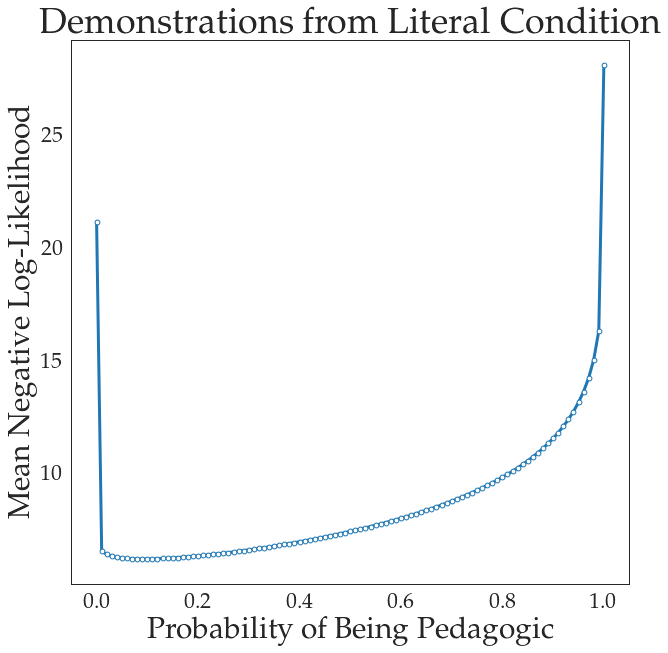

In [71]:
plot_lls(mixtures, -do_lls, title='Demonstrations from Literal Condition', filename='do_mixture_lls')

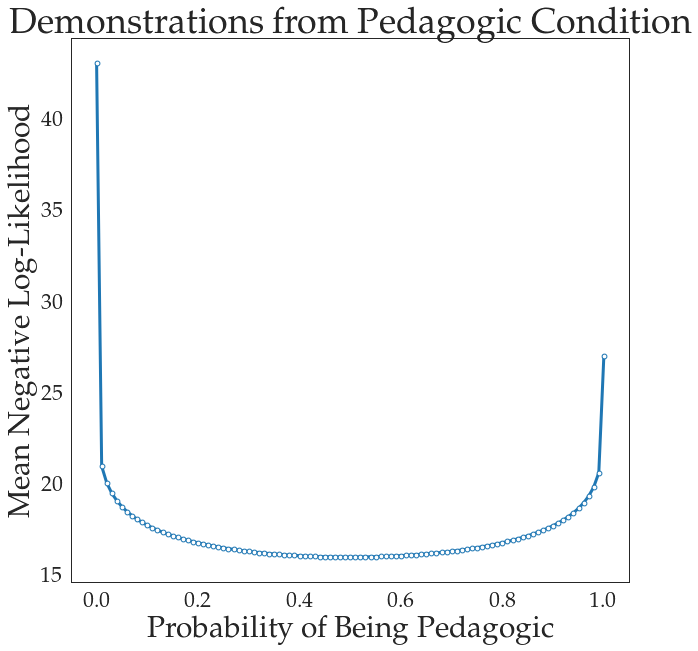

In [72]:
plot_lls(mixtures, -lls, title='Demonstrations from Pedagogic Condition', filename='ped_mix_lls')